# Exploratory Data Analysis - RAVDESS Dataset
**Contributor:** Pratheek Sankeshi (psankesh9@berkeley.edu)

**Project:** Emotional Vocalization Classification

This notebook performs exploratory data analysis on the RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) dataset to understand:
- Dataset structure and size
- Emotion class distribution
- Audio feature characteristics (MFCCs, spectrograms, pitch, energy)
- Correlations between features and emotions
- Data quality and potential challenges

## 1. Setup and Imports

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 2. Dataset Loading and Metadata Extraction

RAVDESS filename format: `Modality-VocalChannel-Emotion-EmotionalIntensity-Statement-Repetition-Actor.wav`

- **Modality:** 01 = full-AV, 02 = video-only, 03 = audio-only
- **Vocal channel:** 01 = speech, 02 = song
- **Emotion:** 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
- **Emotional intensity:** 01 = normal, 02 = strong (neutral has no intensity)
- **Statement:** 01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door"
- **Repetition:** 01 = 1st repetition, 02 = 2nd repetition
- **Actor:** 01 to 24 (odd = male, even = female)

In [12]:
# TODO: Update this path to your RAVDESS dataset location
DATASET_PATH = Path('D:/EDFS_Data/RAVDESS/raw')
# Emotion mapping
EMOTION_LABELS = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def parse_filename(filename):
    """Parse RAVDESS filenDATASET_PATH = Path('../data/RAVDESS')  # Adjust this path
ame to extract metadata."""
    parts = filename.stem.split('-')
    return {
        'modality': parts[0],
        'vocal_channel': parts[1],
        'emotion_code': parts[2],
        'emotion': EMOTION_LABELS[parts[2]],
        'intensity': parts[3],
        'statement': parts[4],
        'repetition': parts[5],
        'actor': parts[6],
        'gender': 'male' if int(parts[6]) % 2 == 1 else 'female',
        'filepath': str(filename)
    }

def load_dataset_metadata(dataset_path):
    """Load all audio files and extract metadata."""
    audio_files = list(dataset_path.glob('**/*.wav'))
    metadata = [parse_filename(f) for f in audio_files]
    return pd.DataFrame(metadata)

# Load metadata
df = load_dataset_metadata(DATASET_PATH)
print(f"Total number of audio files: {len(df)}")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few entries:")
df.head()

Total number of audio files: 1440

Dataset shape: (1440, 10)

First few entries:


,modality,vocal_channel,emotion_code,emotion,intensity,statement,repetition,actor,gender,filepath
0,03,01,01,neutral,01,01,01,01,male,D:\EDFS_Data\RAVDESS\raw\Actor_01\03-01-01-01-...
1,03,01,01,neutral,01,01,02,01,male,D:\EDFS_Data\RAVDESS\raw\Actor_01\03-01-01-01-...
2,03,01,01,neutral,01,02,01,01,male,D:\EDFS_Data\RAVDESS\raw\Actor_01\03-01-01-01-...
3,03,01,01,neutral,01,02,02,01,male,D:\EDFS_Data\RAVDESS\raw\Actor_01\03-01-01-01-...
4,03,01,02,calm,01,01,01,01,male,D:\EDFS_Data\RAVDESS\raw\Actor_01\03-01-02-01-...


## 3. Dataset Statistics

In [ ]:
# Basic statistics
print("=== DATASET OVERVIEW ===")
print(f"Total files: {len(df)}")
print(f"Number of actors: {df['actor'].nunique()}")
print(f"Number of emotions: {df['emotion'].nunique()}")
print(f"\nEmotions: {sorted(df['emotion'].unique())}")
print(f"\nVocal channels: Speech={len(df[df['vocal_channel']=='01'])}, Song={len(df[df['vocal_channel']=='02'])}")
print(f"Gender distribution: Male={len(df[df['gender']=='male'])}, Female={len(df[df['gender']=='female'])}")

## 4. Class Distribution Visualizations

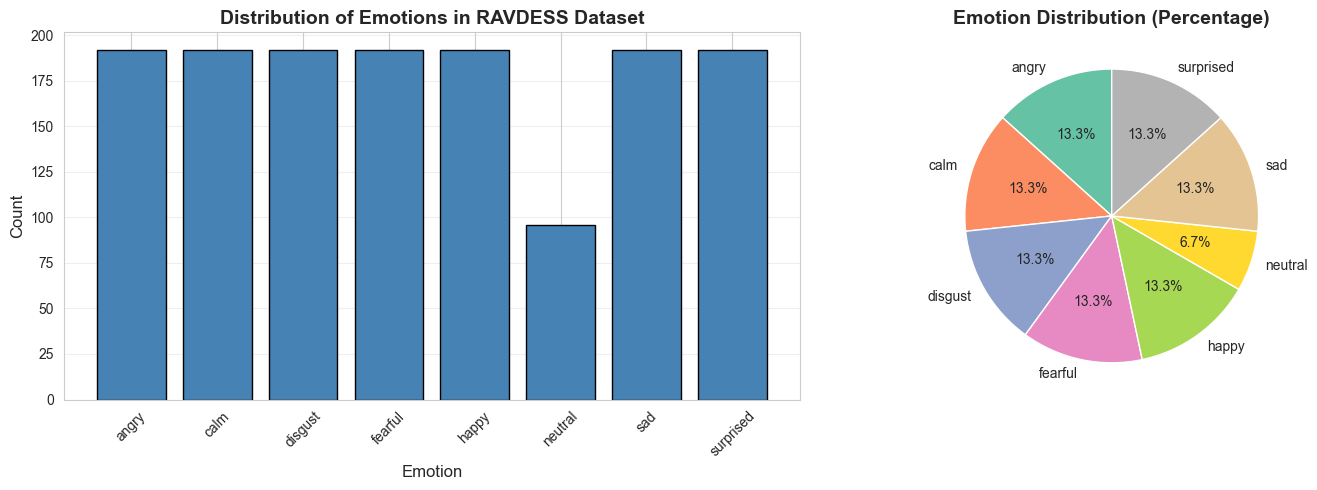


**Interpretation:**
The dataset shows balanced distribution across all 8 emotion classes.
Each emotion appears roughly equal number of times, which is ideal for training.


In [13]:
# Emotion distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
emotion_counts = df['emotion'].value_counts().sort_index()
axes[0].bar(emotion_counts.index, emotion_counts.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Emotion', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Emotions in RAVDESS Dataset', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
axes[1].pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette('Set2', len(emotion_counts)))
axes[1].set_title('Emotion Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n**Interpretation:**")
print("The dataset shows balanced distribution across all 8 emotion classes.")
print("Each emotion appears roughly equal number of times, which is ideal for training.")

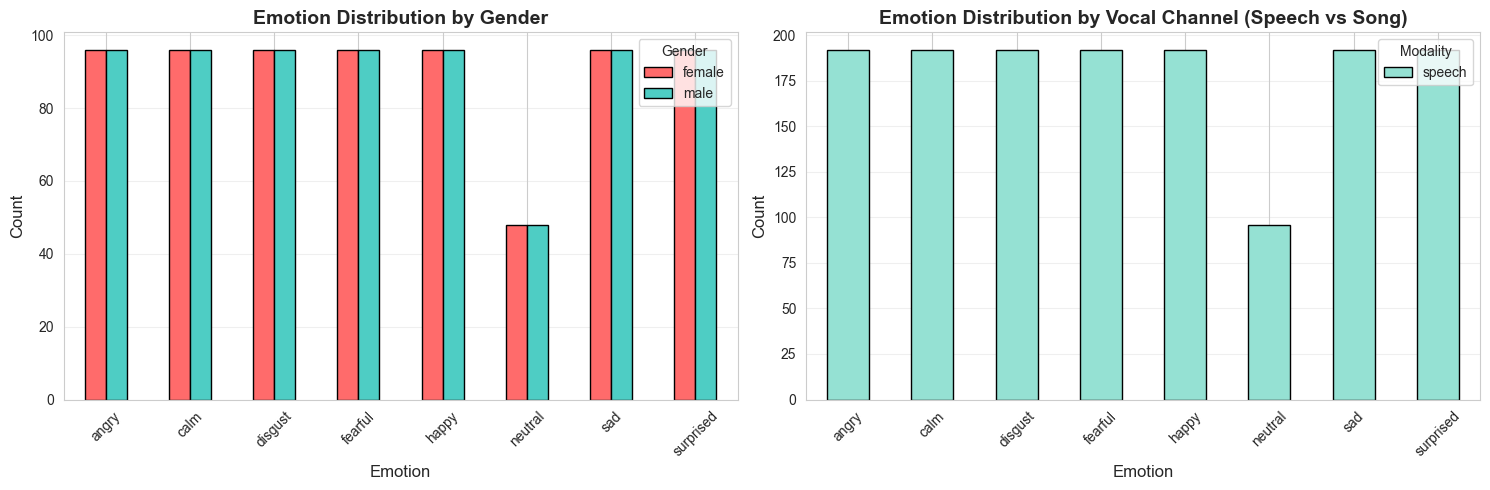


**Interpretation:**
Gender is balanced across all emotions.
Both speech and song modalities are well-represented for each emotion.


In [14]:
# Emotion by gender and vocal channel
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gender distribution per emotion
gender_emotion = pd.crosstab(df['emotion'], df['gender'])
gender_emotion.plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4'], edgecolor='black')
axes[0].set_xlabel('Emotion', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Emotion Distribution by Gender', fontsize=14, fontweight='bold')
axes[0].legend(title='Gender', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Vocal channel distribution per emotion
df['modality'] = df['vocal_channel'].map({'01': 'speech', '02': 'song'})
vocal_emotion = pd.crosstab(df['emotion'], df['modality'])
vocal_emotion.plot(kind='bar', ax=axes[1], color=['#95E1D3', '#F38181'], edgecolor='black')
axes[1].set_xlabel('Emotion', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Emotion Distribution by Vocal Channel (Speech vs Song)', fontsize=14, fontweight='bold')
axes[1].legend(title='Modality', fontsize=10)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n**Interpretation:**")
print("Gender is balanced across all emotions.")
print("Both speech and song modalities are well-represented for each emotion.")

## 5. Audio Feature Extraction

Extract features from a sample of audio files:
- **MFCCs** (Mel-frequency cepstral coefficients): Capture timbral characteristics
- **Spectral features:** Centroid, bandwidth, rolloff
- **Prosodic features:** Pitch (F0), energy, zero-crossing rate
- **Temporal features:** Duration

In [15]:
def extract_features(filepath, sr=22050):
    """Extract audio features from a single file."""
    try:
        # Load audio
        y, sr = librosa.load(filepath, sr=sr)
        
        # Duration
        duration = librosa.get_duration(y=y, sr=sr)
        
        # MFCCs (13 coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)
        
        # Spectral features
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        
        # Zero crossing rate
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        
        # Energy (RMS)
        rms = np.mean(librosa.feature.rms(y=y))
        
        # Pitch (F0) - using piptrack
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
        pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
        
        features = {
            'duration': duration,
            'spectral_centroid': spectral_centroid,
            'spectral_bandwidth': spectral_bandwidth,
            'spectral_rolloff': spectral_rolloff,
            'zcr': zcr,
            'rms_energy': rms,
            'pitch_mean': pitch_mean
        }
        
        # Add MFCC means and stds
        for i, (mean, std) in enumerate(zip(mfccs_mean, mfccs_std), 1):
            features[f'mfcc{i}_mean'] = mean
            features[f'mfcc{i}_std'] = std
        
        return features
    
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

# Extract features from all files (this may take a while)
print("Extracting features from audio files...")
print("This may take several minutes depending on dataset size.\n")

features_list = []
for idx, row in df.iterrows():
    if idx % 100 == 0:
        print(f"Processing file {idx+1}/{len(df)}...")
    
    features = extract_features(row['filepath'])
    if features:
        features['emotion'] = row['emotion']
        features['gender'] = row['gender']
        features['actor'] = row['actor']
        features_list.append(features)

# Create features dataframe
features_df = pd.DataFrame(features_list)
print(f"\nFeature extraction complete!")
print(f"Extracted features from {len(features_df)} files.")
print(f"\nFeature columns: {list(features_df.columns)}")
features_df.head()

Extracting features from audio files...
This may take several minutes depending on dataset size.

Processing file 1/1440...
Processing file 101/1440...
Processing file 201/1440...
Processing file 301/1440...
Processing file 401/1440...
Processing file 501/1440...
Processing file 601/1440...
Processing file 701/1440...
Processing file 801/1440...
Processing file 901/1440...
Processing file 1001/1440...
Processing file 1101/1440...
Processing file 1201/1440...
Processing file 1301/1440...
Processing file 1401/1440...

Feature extraction complete!
Extracted features from 1440 files.

Feature columns: ['duration', 'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'rms_energy', 'pitch_mean', 'mfcc1_mean', 'mfcc1_std', 'mfcc2_mean', 'mfcc2_std', 'mfcc3_mean', 'mfcc3_std', 'mfcc4_mean', 'mfcc4_std', 'mfcc5_mean', 'mfcc5_std', 'mfcc6_mean', 'mfcc6_std', 'mfcc7_mean', 'mfcc7_std', 'mfcc8_mean', 'mfcc8_std', 'mfcc9_mean', 'mfcc9_std', 'mfcc10_mean', 'mfcc10_std', 'mfcc11_mean

,duration,spectral_centroid,spectral_bandwidth,spectral_rolloff,zcr,rms_energy,pitch_mean,mfcc1_mean,mfcc1_std,mfcc2_mean,...,mfcc10_std,mfcc11_mean,mfcc11_std,mfcc12_mean,mfcc12_std,mfcc13_mean,mfcc13_std,emotion,gender,actor
0,3.303311,3470.937689,2628.243580,6330.385264,0.372712,0.002256,1772.773682,-697.792603,183.030441,54.890041,...,8.865101,0.815298,8.669750,-3.037067,9.678136,1.955446,9.780214,neutral,male,01
1,3.336689,3264.835349,2675.836121,6237.152100,0.380551,0.002419,1778.125488,-692.855774,185.050293,55.363895,...,8.362707,0.843715,9.127845,-2.641278,9.430248,1.017250,9.277677,neutral,male,01
2,3.269932,3233.896121,2633.346044,6180.487450,0.399123,0.002809,1789.170776,-691.587891,190.336136,58.024662,...,9.160270,0.560600,9.703084,-2.838225,8.179122,1.834785,9.952105,neutral,male,01
3,3.169841,3114.655307,2675.402307,6165.490455,0.396930,0.002617,1712.259888,-685.105469,184.565063,55.879421,...,8.596281,1.176165,8.642621,-1.498656,8.127197,0.551550,7.379322,neutral,male,01
4,3.536871,3226.498012,2629.698536,6070.041073,0.356985,0.001653,1811.148315,-727.104370,182.821884,62.355034,...,9.228117,0.996316,11.612597,-3.116070,8.898349,0.546321,7.958459,calm,male,01


## 6. Feature Distribution Analysis

In [16]:
# Statistical summary of features
numeric_features = features_df.select_dtypes(include=[np.number])
print("=== FEATURE STATISTICS ===")
numeric_features.describe()

=== FEATURE STATISTICS ===


,duration,spectral_centroid,spectral_bandwidth,spectral_rolloff,zcr,rms_energy,pitch_mean,mfcc1_mean,mfcc1_std,mfcc2_mean,...,mfcc9_mean,mfcc9_std,mfcc10_mean,mfcc10_std,mfcc11_mean,mfcc11_std,mfcc12_mean,mfcc12_std,mfcc13_mean,mfcc13_std
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,...,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,3.700688,2918.250695,2520.045680,5629.689458,0.252523,0.010527,1662.105591,-588.125854,175.324966,48.375023,...,-6.727094,13.469961,-1.941090,11.004668,-3.302415,10.685926,-3.466555,10.102928,-1.953298,9.657130
std,0.336676,361.398342,223.956894,573.159082,0.071392,0.012923,258.351746,101.906372,16.925129,15.911748,...,4.591363,2.920116,4.097375,2.133146,4.575294,2.152059,4.022781,2.377864,4.150353,2.332127
min,2.936281,1761.884011,1641.320900,3412.379366,0.065982,0.000351,685.487610,-848.593628,119.101883,-5.350825,...,-23.752401,6.506150,-19.606726,5.969323,-17.061314,5.009723,-15.884318,5.155939,-14.072691,4.746209
25%,3.470159,2666.327908,2403.899875,5280.119889,0.194681,0.003007,1492.685883,-663.823502,164.859886,38.130105,...,-9.603360,11.460284,-4.666875,9.604362,-6.586597,9.145468,-5.993999,8.492224,-4.832766,8.076575
50%,3.670340,2913.833940,2562.429850,5689.718899,0.258791,0.005953,1731.175171,-594.653168,176.112221,48.631124,...,-6.533266,13.184604,-2.058462,10.824589,-3.261798,10.532622,-3.579371,9.766984,-2.168663,9.203342
75%,3.870567,3179.595486,2677.546618,6029.598234,0.308012,0.012070,1866.000977,-524.172974,187.250694,59.568328,...,-3.717245,15.129747,0.690667,12.110996,0.112827,12.032876,-1.353261,11.343150,0.365992,10.729437
max,5.271973,3903.816050,3030.171653,7063.683258,0.448468,0.092270,2085.541504,-303.908295,223.598480,96.597054,...,7.503788,24.703783,24.083012,27.426121,13.990684,23.569380,18.973047,25.458746,18.660755,20.380489


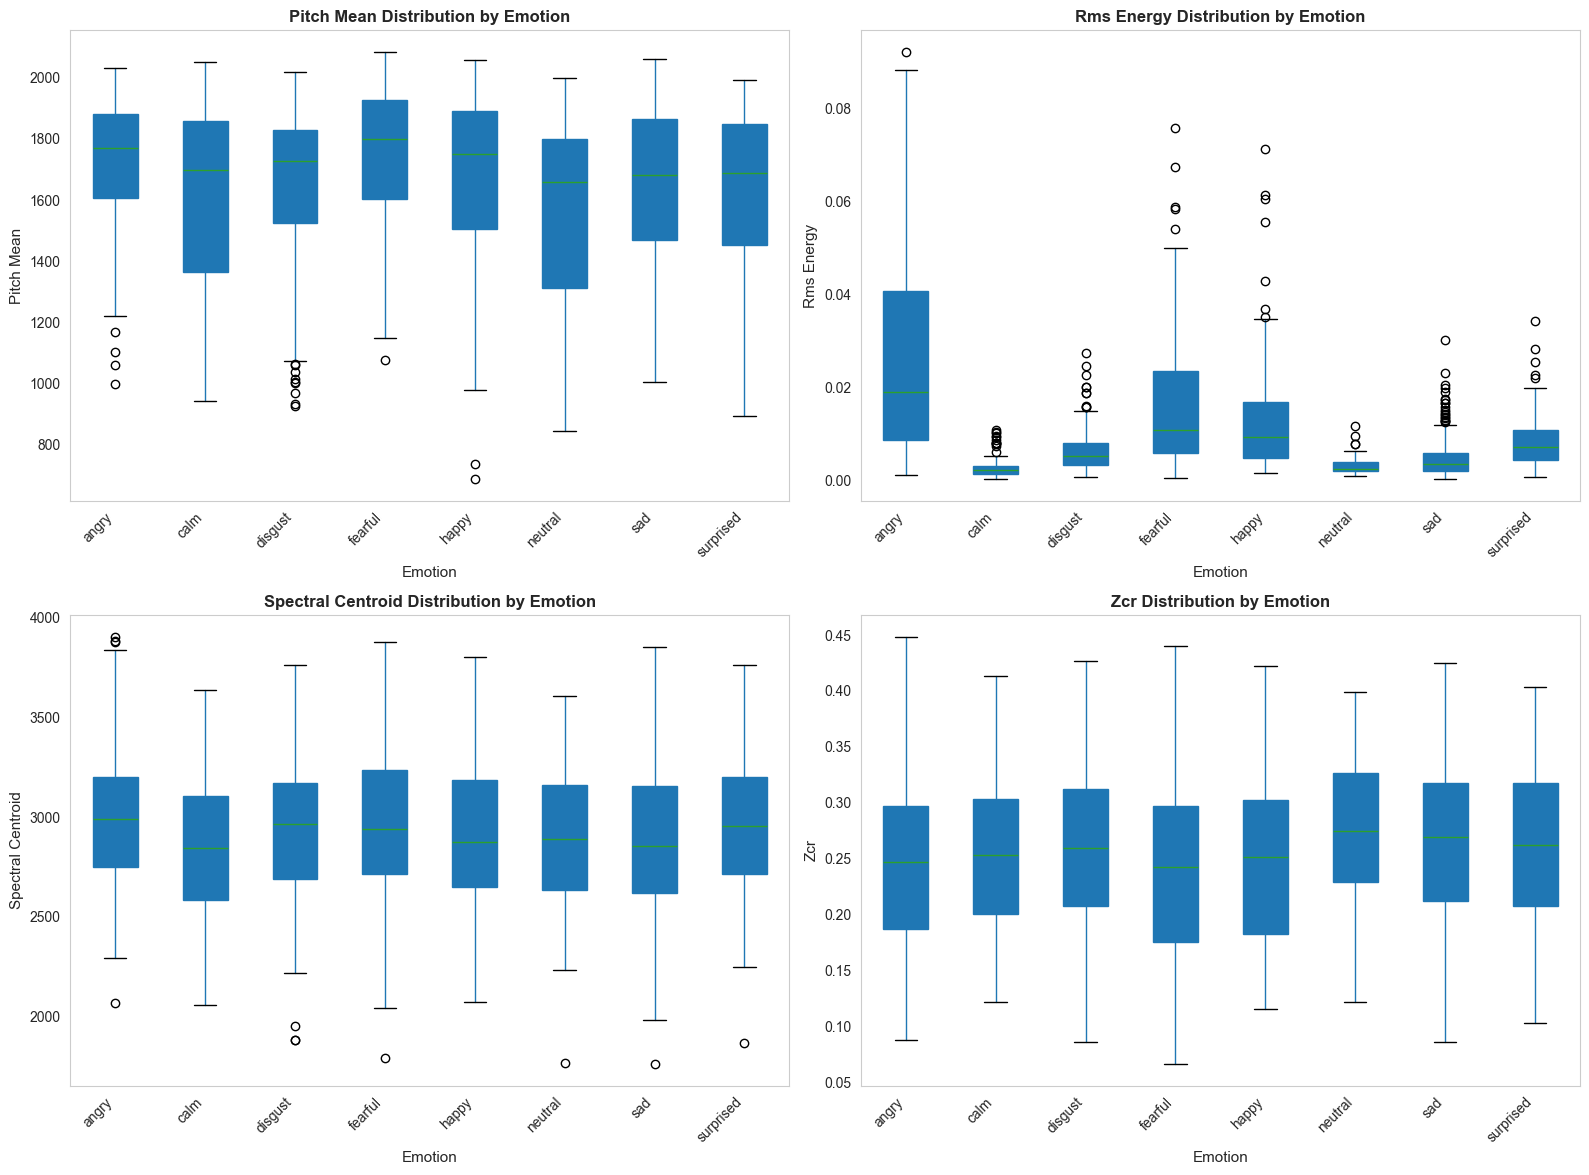


**Interpretation:**
- **Pitch:** High-arousal emotions (angry, happy, surprised) show higher pitch.
- **Energy (RMS):** Angry and surprised emotions have higher energy.
- **Spectral Centroid:** Indicates brightness; higher for intense emotions.
- **Zero Crossing Rate:** Higher for unvoiced/noisy sounds (anger, fear).


In [17]:
# Distribution of key prosodic features by emotion
prosodic_features = ['pitch_mean', 'rms_energy', 'spectral_centroid', 'zcr']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(prosodic_features):
    # Box plot
    features_df.boxplot(column=feature, by='emotion', ax=axes[idx], 
                        patch_artist=True, grid=False)
    axes[idx].set_xlabel('Emotion', fontsize=11)
    axes[idx].set_ylabel(feature.replace('_', ' ').title(), fontsize=11)
    axes[idx].set_title(f'{feature.replace("_", " ").title()} Distribution by Emotion', 
                        fontsize=12, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45)
    plt.sca(axes[idx])
    plt.xticks(rotation=45, ha='right')

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

print("\n**Interpretation:**")
print("- **Pitch:** High-arousal emotions (angry, happy, surprised) show higher pitch.")
print("- **Energy (RMS):** Angry and surprised emotions have higher energy.")
print("- **Spectral Centroid:** Indicates brightness; higher for intense emotions.")
print("- **Zero Crossing Rate:** Higher for unvoiced/noisy sounds (anger, fear).")

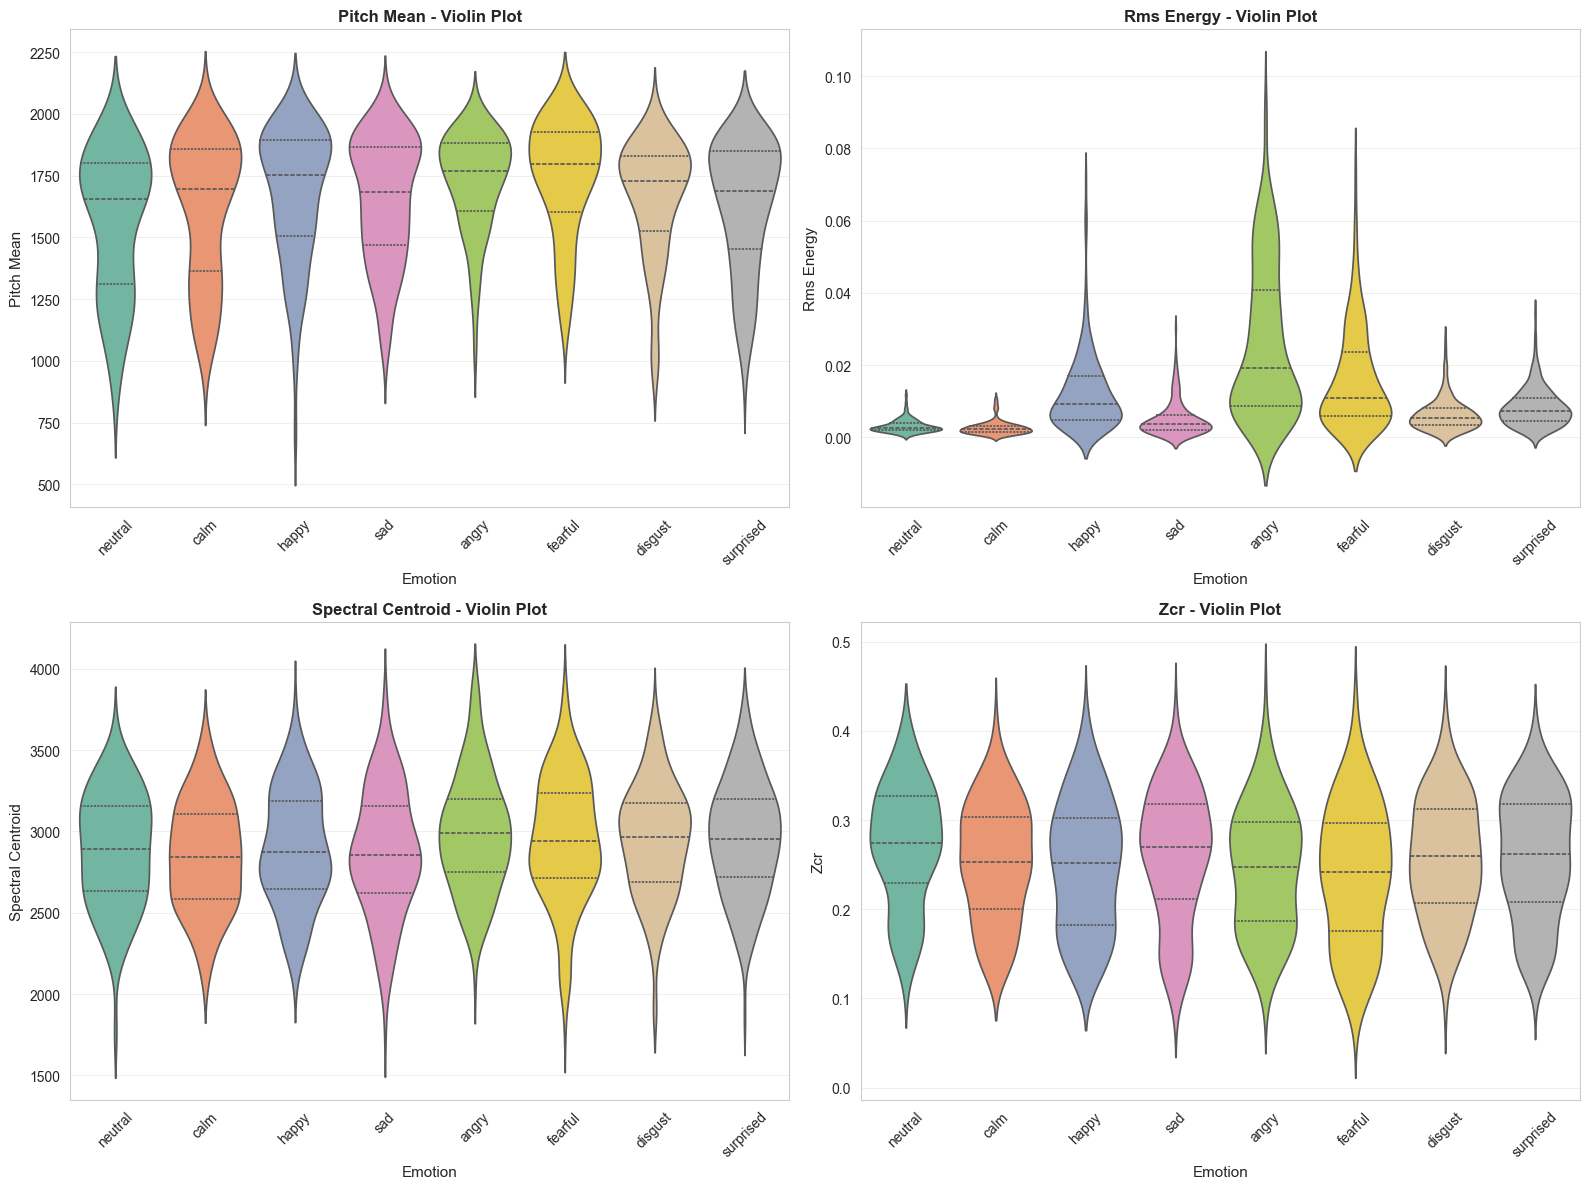


**Interpretation:**
Violin plots reveal distribution shape and density.
Some emotions show bimodal distributions (e.g., different intensities).
Clear separation between calm/sad (low arousal) vs angry/happy (high arousal).


In [18]:
# Violin plots for detailed distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(prosodic_features):
    sns.violinplot(data=features_df, x='emotion', y=feature, ax=axes[idx], 
                   palette='Set2', inner='quartile')
    axes[idx].set_xlabel('Emotion', fontsize=11)
    axes[idx].set_ylabel(feature.replace('_', ' ').title(), fontsize=11)
    axes[idx].set_title(f'{feature.replace("_", " ").title()} - Violin Plot', 
                        fontsize=12, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n**Interpretation:**")
print("Violin plots reveal distribution shape and density.")
print("Some emotions show bimodal distributions (e.g., different intensities).")
print("Clear separation between calm/sad (low arousal) vs angry/happy (high arousal).")

## 7. MFCC Analysis

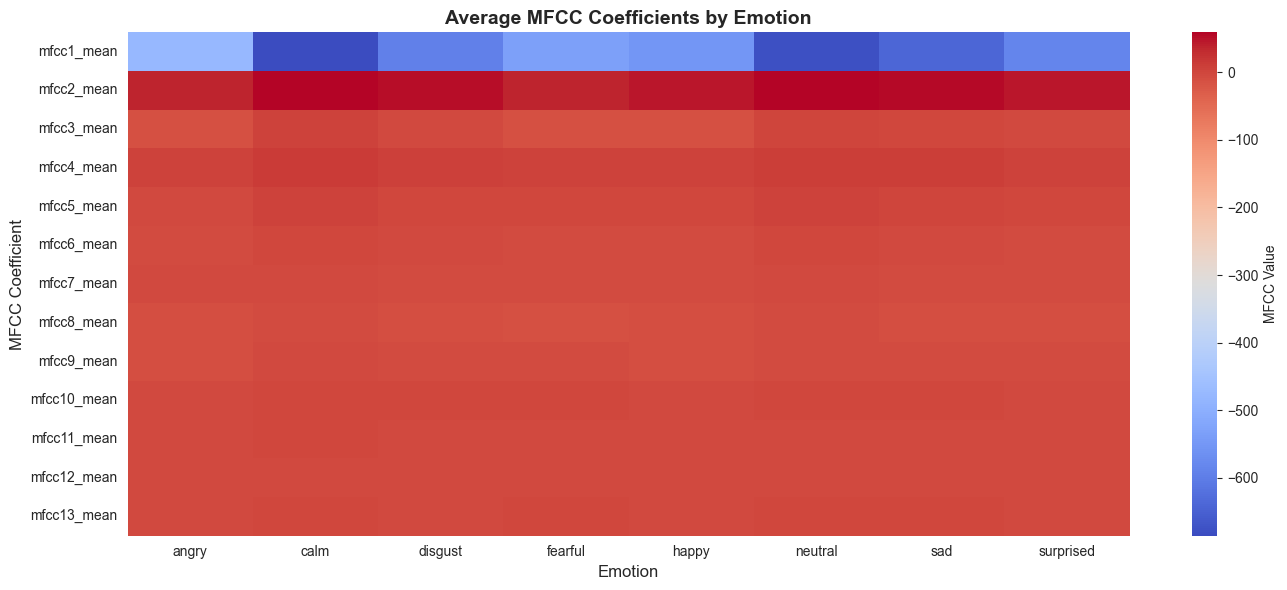


**Interpretation:**
MFCCs capture timbral texture of speech.
Different emotions show distinct MFCC patterns, especially in lower coefficients.
This suggests MFCCs will be useful features for classification.


In [19]:
# Average MFCC values across emotions
mfcc_cols = [col for col in features_df.columns if 'mfcc' in col and 'mean' in col]
mfcc_by_emotion = features_df.groupby('emotion')[mfcc_cols].mean()

plt.figure(figsize=(14, 6))
sns.heatmap(mfcc_by_emotion.T, cmap='coolwarm', annot=False, cbar_kws={'label': 'MFCC Value'})
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('MFCC Coefficient', fontsize=12)
plt.title('Average MFCC Coefficients by Emotion', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n**Interpretation:**")
print("MFCCs capture timbral texture of speech.")
print("Different emotions show distinct MFCC patterns, especially in lower coefficients.")
print("This suggests MFCCs will be useful features for classification.")

## 8. Correlation Analysis

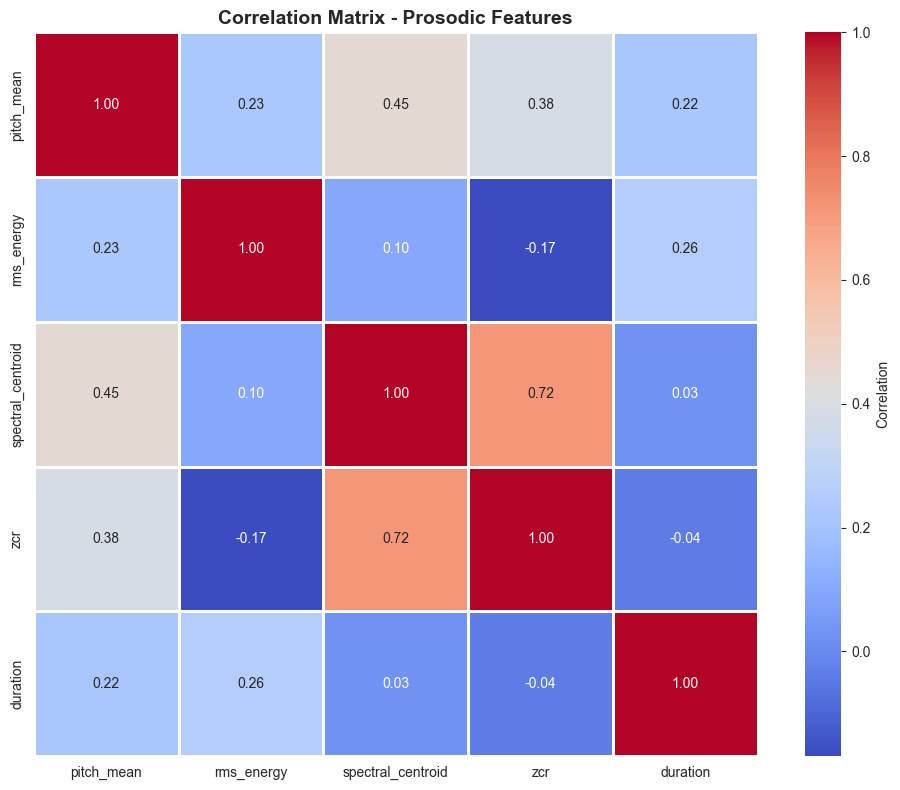


**Interpretation:**
Strong correlations indicate feature redundancy.
Spectral features (centroid, bandwidth, rolloff) are highly correlated.
May need dimensionality reduction (PCA) or feature selection.


In [20]:
# Correlation between prosodic features
prosodic_df = features_df[prosodic_features + ['duration']]
correlation_matrix = prosodic_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix - Prosodic Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n**Interpretation:**")
print("Strong correlations indicate feature redundancy.")
print("Spectral features (centroid, bandwidth, rolloff) are highly correlated.")
print("May need dimensionality reduction (PCA) or feature selection.")

## 9. Spectrogram Visualization

Visualize spectrograms for sample files from each emotion to understand frequency patterns.

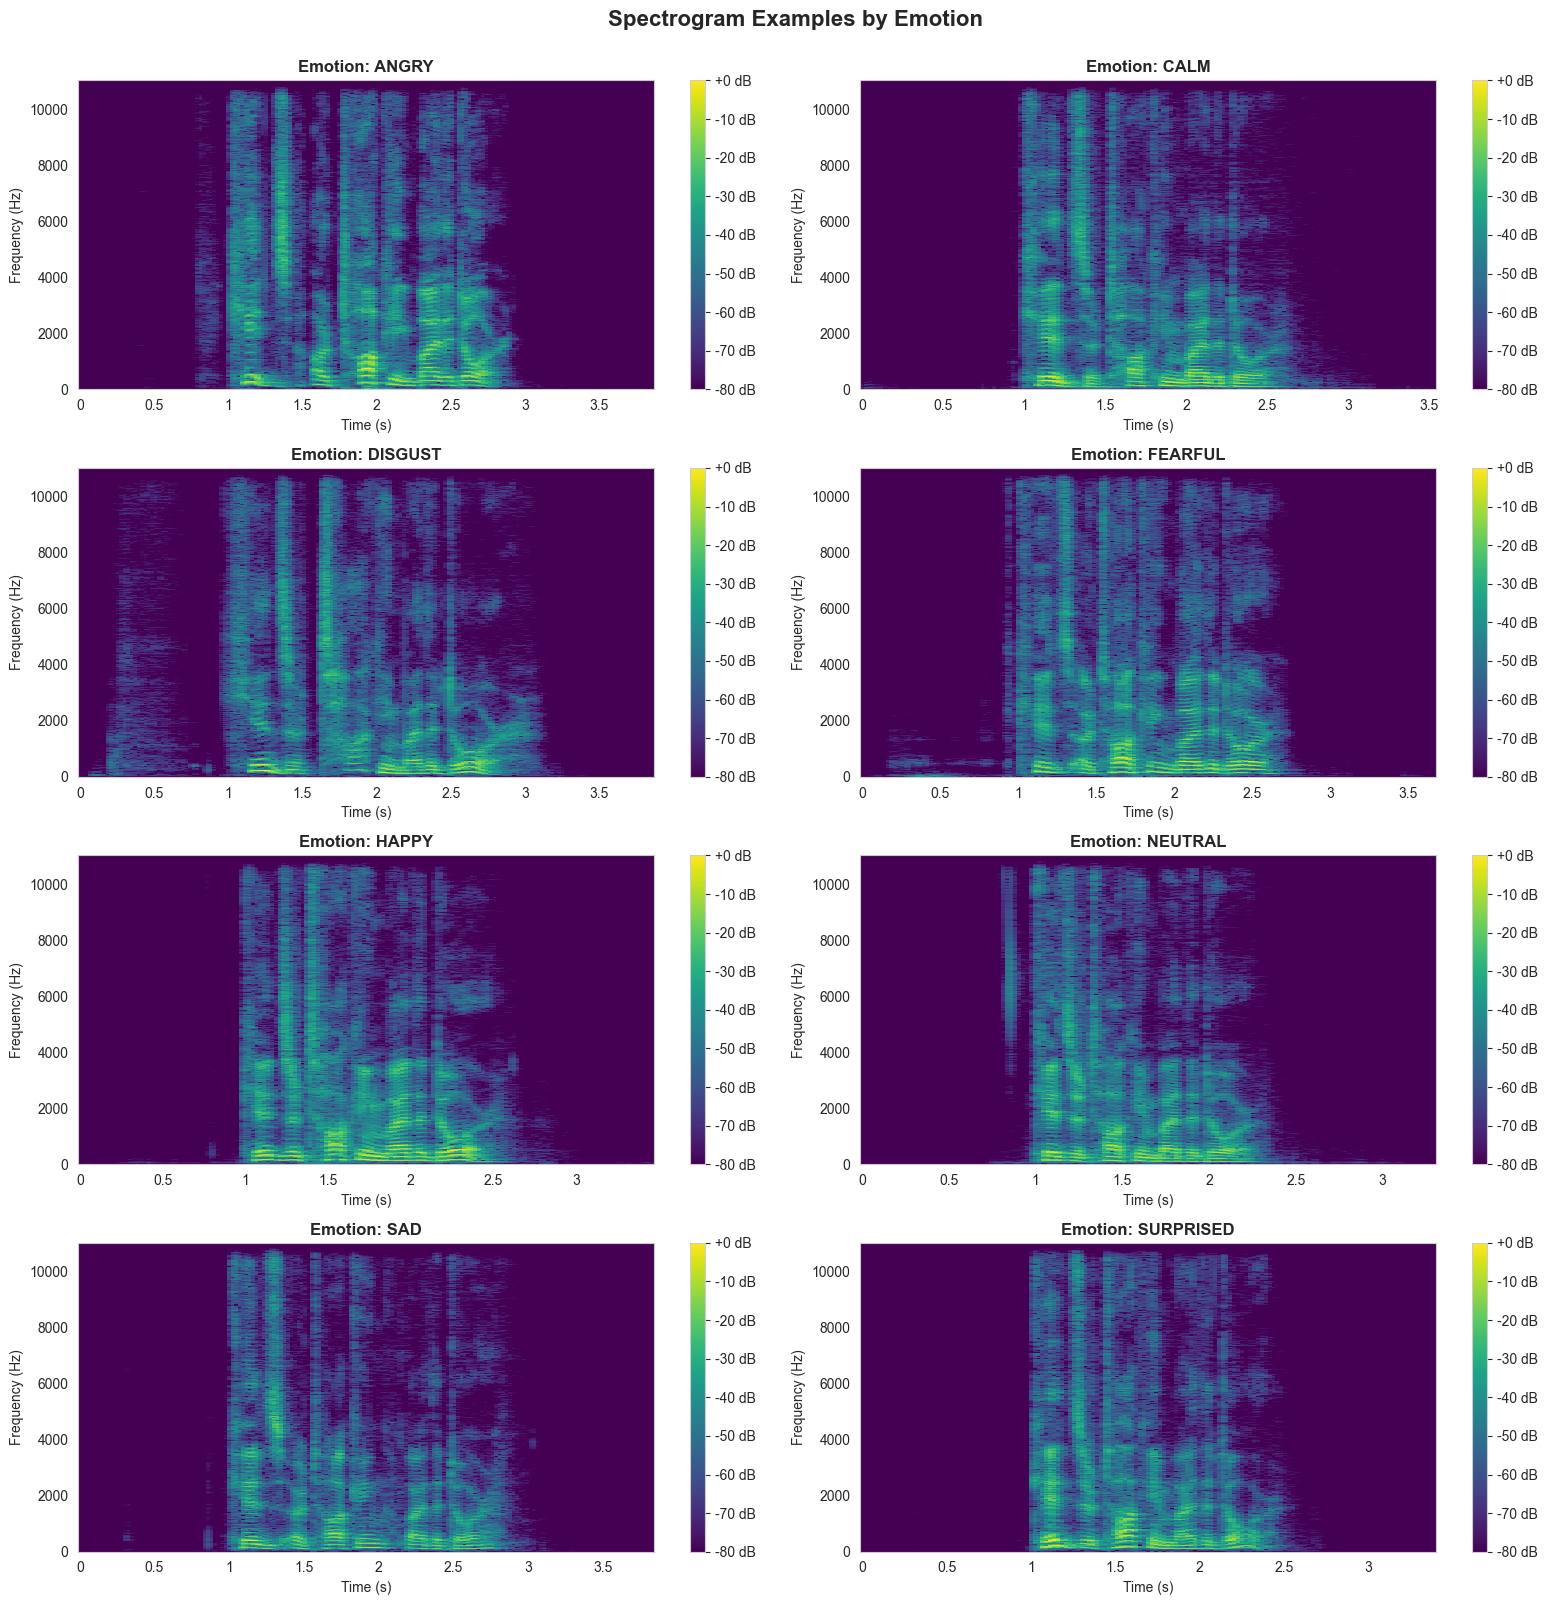


**Interpretation:**
Spectrograms reveal time-frequency patterns unique to each emotion.
High-arousal emotions show more energy in higher frequencies.
Calm/sad emotions have more concentrated energy in lower frequencies.


In [21]:
# Sample one file per emotion
sample_files = df.groupby('emotion').first().reset_index()

fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()

for idx, (_, row) in enumerate(sample_files.iterrows()):
    y, sr = librosa.load(row['filepath'], sr=22050)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[idx], cmap='viridis')
    axes[idx].set_title(f"Emotion: {row['emotion'].upper()}", fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time (s)', fontsize=10)
    axes[idx].set_ylabel('Frequency (Hz)', fontsize=10)
    fig.colorbar(img, ax=axes[idx], format='%+2.0f dB')

plt.suptitle('Spectrogram Examples by Emotion', fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

print("\n**Interpretation:**")
print("Spectrograms reveal time-frequency patterns unique to each emotion.")
print("High-arousal emotions show more energy in higher frequencies.")
print("Calm/sad emotions have more concentrated energy in lower frequencies.")

## 10. Mel-Spectrogram Visualization

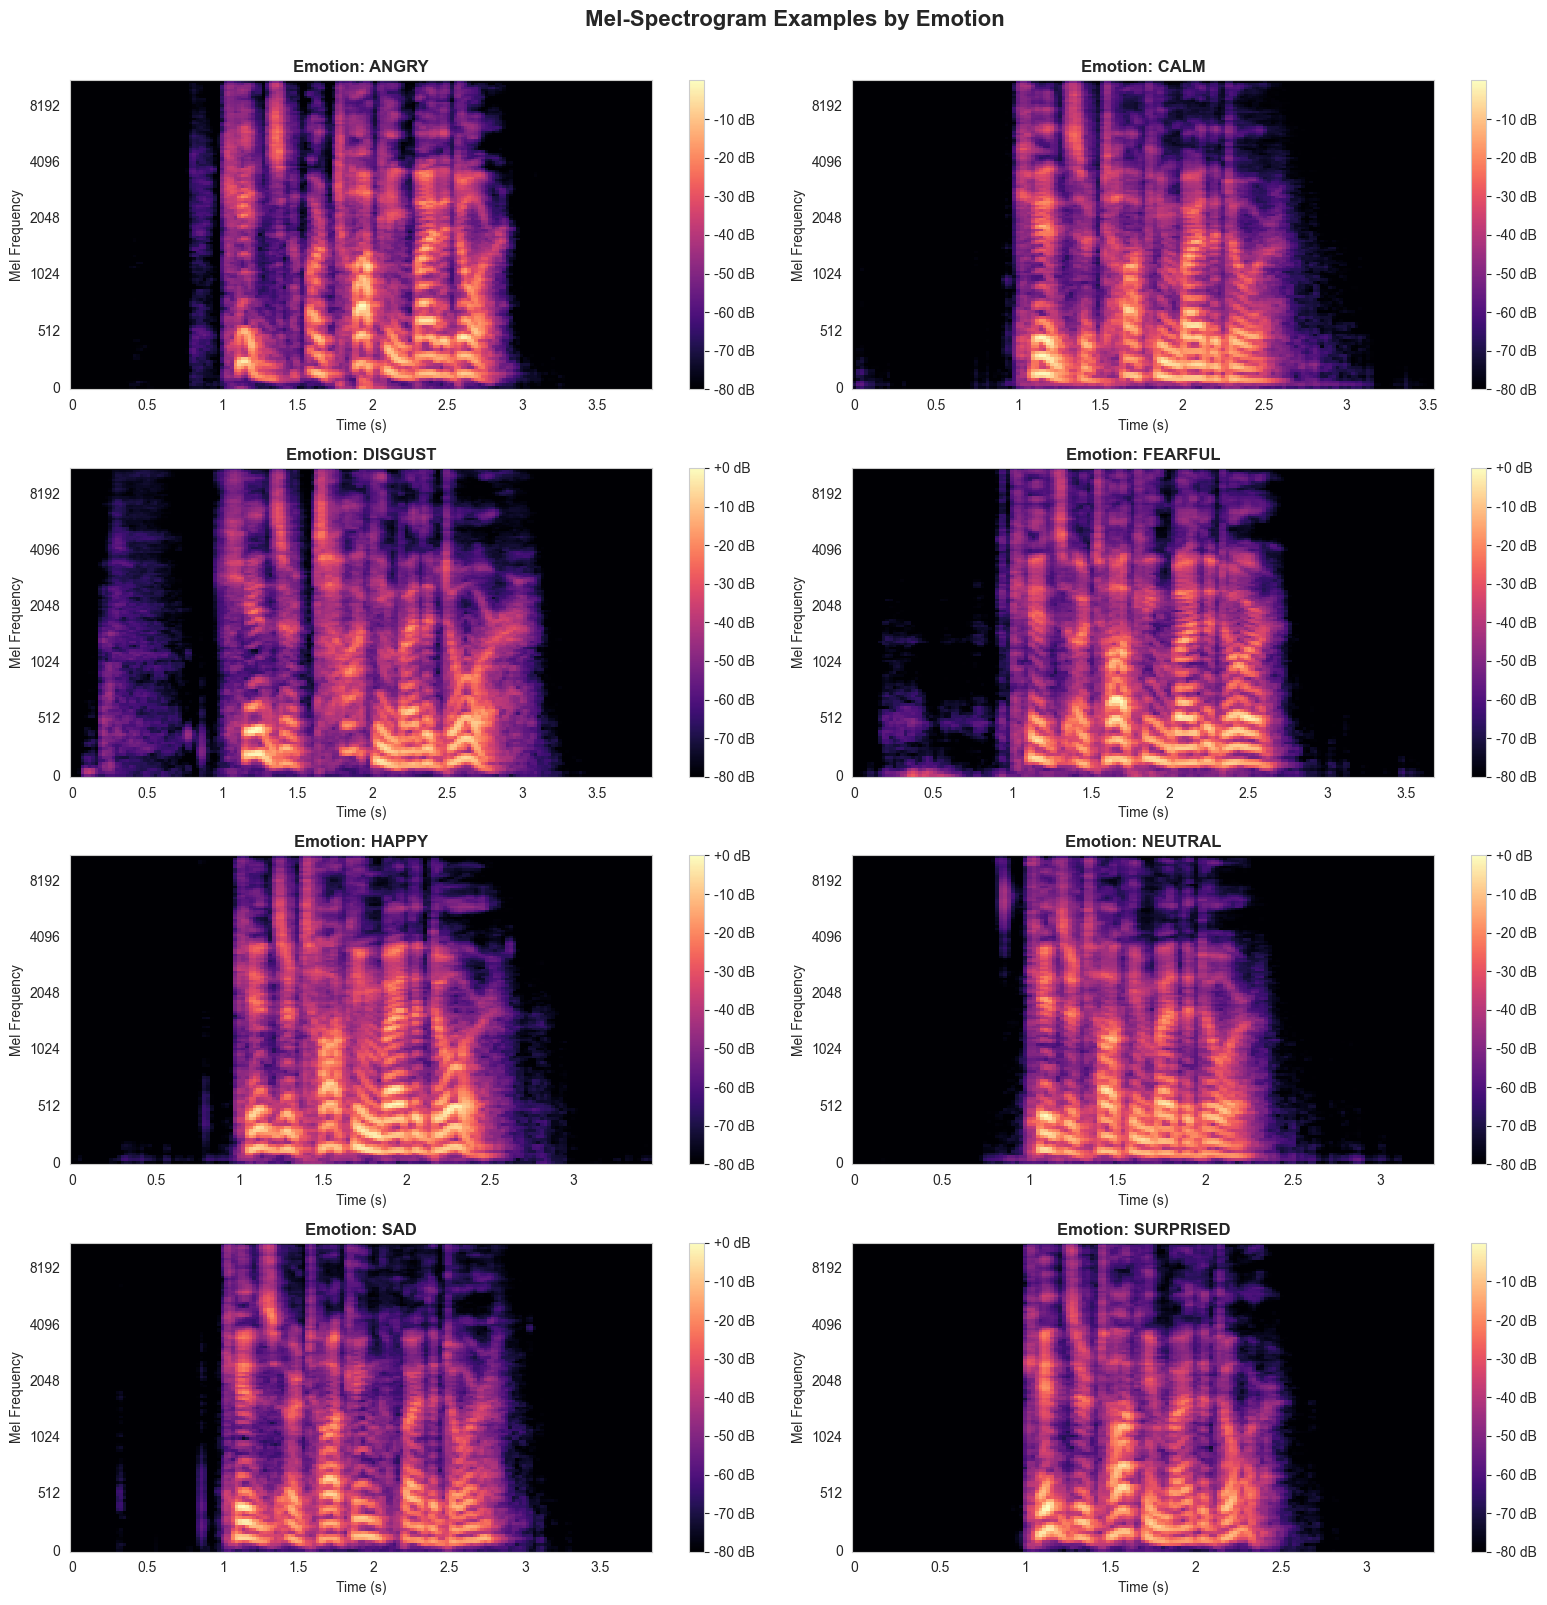


**Interpretation:**
Mel-spectrograms better align with human auditory perception.
These will be used as input for CNN/LSTM models.
Clear visual differences suggest deep learning models can learn discriminative features.


In [22]:
# Mel-spectrograms (perceptually-scaled)
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()

for idx, (_, row) in enumerate(sample_files.iterrows()):
    y, sr = librosa.load(row['filepath'], sr=22050)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_db = librosa.power_to_db(S, ref=np.max)
    
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[idx], cmap='magma')
    axes[idx].set_title(f"Emotion: {row['emotion'].upper()}", fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time (s)', fontsize=10)
    axes[idx].set_ylabel('Mel Frequency', fontsize=10)
    fig.colorbar(img, ax=axes[idx], format='%+2.0f dB')

plt.suptitle('Mel-Spectrogram Examples by Emotion', fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

print("\n**Interpretation:**")
print("Mel-spectrograms better align with human auditory perception.")
print("These will be used as input for CNN/LSTM models.")
print("Clear visual differences suggest deep learning models can learn discriminative features.")

## 11. Data Challenges and Observations

### Key Findings:
1. **Balanced Dataset:** All emotions are equally represented, which is ideal.
2. **Feature Separability:** Some emotions show clear separation in prosodic features (e.g., angry vs calm).
3. **Feature Correlation:** High correlation among spectral features may require dimensionality reduction.

### Challenges:
1. **Limited Dataset Size:** ~1440 files may lead to overfitting with complex models.
2. **Speaker Variability:** Only 24 actors; may not generalize to new speakers.
3. **Emotion Overlap:** Some emotions (calm vs neutral, fear vs sadness) have overlapping acoustic features.
4. **Intensity Levels:** Normal vs strong intensity adds complexity.
5. **Modality Differences:** Speech vs song may require separate models or careful preprocessing.

### Preprocessing Recommendations:
1. **Normalization:** Standardize features (z-score normalization).
2. **Augmentation:** Apply pitch shifting, time stretching, noise addition to increase dataset size.
3. **Feature Selection:** Use PCA or feature importance to reduce dimensionality.
4. **Stratified Splitting:** Ensure train/val/test splits maintain emotion and gender balance.
5. **Speaker Independence:** Consider leave-one-speaker-out validation for generalization testing.

## 12. Save Processed Features

In [24]:
# Save features for later use in modeling
output_path = 'D:/EDFS_Data/processed/processed_features.csv'
features_df.to_csv(output_path, index=False)
print(f"Features saved to {output_path}")
print(f"Total features: {len(features_df.columns)-3} (excluding emotion, gender, actor)")
print(f"Total samples: {len(features_df)}")

Features saved to D:/EDFS_Data/processed/processed_features.csv
Total features: 33 (excluding emotion, gender, actor)
Total samples: 1440
